In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '86-efficientnetb4'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 32,
  "EPOCHS": 12,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 11,
  "BASE_MODEL": 'EfficientNetB4',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB4',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 32,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-384x384',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 384,
 'LEARNING_RATE': 0.001,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 11,
 'WIDTH': 384}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
#     p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_pixel >= .2: # Pixel-level transforms
      if p_pixel >= .75:
        image = data_augment_saturation(image)
      elif p_pixel >= .5:
        image = data_augment_contrast(image)
      else:
        image = data_augment_brightness(image)

    if p_rotation >= .2: # Rotation
      image = data_augment_rotation(image)

    if p_spatial2 >= .2: 
      if p_spatial2 >= .6: # Shift
        image = data_augment_shift(image)
      else: # Shear
        image = data_augment_shear(image)
        
    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image = data_augment_spatial(image)
      else: # Rotate
        image = data_augment_rotate(image)

    if p_crop >= .2: # Crops
      image = data_augment_crop(image)
    
#     if p_cutout >= .2: # Cutout
#       image = data_augment_cutout(image)
    
    return image


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .5:
        if p_crop > .9:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop > .7:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        else:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [10]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = data_augment(img)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

In [11]:
#@title
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

# Model

In [12]:
#@title
# Initial bias
pos = len(train[train['target'] == 1])
neg = len(train[train['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
skf = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []
preds = np.zeros((count_data_items(TEST_FILENAMES), 1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print('\nFOLD: %d' % (fold+1))
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(TRAINING_FILENAMES)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    model_path = f'model_fold_{fold}.h5'
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        opt = optimizers.Adam(learning_rate=0.001)
        loss = losses.BinaryCrossentropy(label_smoothing=0.05) 
        model.compile(optimizer=opt, loss=loss, metrics=['AUC'])
        
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)
   
    # TRAIN
    print('Training...')
    history = model.fit(get_dataset(TRAINING_FILENAMES, augment=True, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']), 
                        validation_data=get_dataset(files_valid, augment=False, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=count_data_items(TRAINING_FILENAMES)/config['BATCH_SIZE']//REPLICAS,
                        epochs=config['EPOCHS'], 
                        callbacks=[checkpoint, get_lr_callback(config['BATCH_SIZE'])], 
                        verbose=2).history
    
    history_list.append(history)

    # save last epoch weights
    model.save_weights(MODEL_BASE_PATH + 'last_' + model_path)
    
    print('Loading best model...')
    model.load_weights(MODEL_BASE_PATH + model_path)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=True,repeat=True, 
                           shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    ct_valid = count_data_items(files_valid)
    STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid,config['TTA_STEPS']),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
            labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
                labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=config['HEIGHT'],batch_size=config['BATCH_SIZE']*4)
    ct_test = count_data_items(TEST_FILENAMES)
    STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=2)[:config['TTA_STEPS']*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,config['TTA_STEPS']), order='F'),axis=1) * (1/config['N_USED_FOLDS'])
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    oof_val.append(np.max( history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1, oof_val[-1],auc))


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


71892992/71892840 [==============================] - 1s 0us/step
Training...
Epoch 1/12
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


102/102 - 102s - auc: 0.5449 - loss: 0.1826 - val_auc: 0.5684 - val_loss: 0.1901 - lr: 5.0000e-06
Epoch 2/12
102/102 - 76s - auc: 0.7712 - loss: 0.1706 - val_auc: 0.7453 - val_loss: 0.1795 - lr: 6.8000e-05
Epoch 3/12
102/102 - 77s - auc: 0.8400 - loss: 0.1676 - val_auc: 0.8529 - val_loss: 0.1680 - lr: 1.3100e-04
Epoch 4/12
102/102 - 73s - auc: 0.8486 - loss: 0.1648 - val_auc: 0.8375 - val_loss: 0.1703 - lr: 1.9400e-04
Epoch 5/12
102/102 - 77s - auc: 0.8706 - loss: 0.1652 - val_auc: 0.8594 - val_loss: 0.1657 - lr: 2.5700e-04
Epoch 6/12
102/102 - 73s - auc: 0.8752 - loss: 0.1608 - val_auc: 0.8564 - val_loss: 0.1661 - lr: 3.2000e-04
Epoch 7/12
102/102 - 73s - auc: 0.8958 - loss: 0.1617 - val_auc: 0.8648 - val_loss: 0.1674 - lr: 2.5620e-04
Epoch 8/12
102/102 - 77s - auc: 0.9098 - loss: 0.1558 - val_auc: 0.8761 - val_loss: 0.1651 - lr: 2.0516e-04
Epoch 9/12
102/102 - 77s - auc: 0.9394 - loss: 0.1549 - val_auc: 0.8670 - val_loss: 0.1634 - lr: 1.6433e-04
Epoch 10/12
102/102 - 73s - auc: 0.950

INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 97s - auc: 0.6140 - loss: 0.1819 - val_auc: 0.5885 - val_loss: 0.1864 - lr: 5.0000e-06
Epoch 2/12
102/102 - 77s - auc: 0.7738 - loss: 0.1700 - val_auc: 0.7288 - val_loss: 0.1786 - lr: 6.8000e-05
Epoch 3/12
102/102 - 77s - auc: 0.8478 - loss: 0.1670 - val_auc: 0.8216 - val_loss: 0.1714 - lr: 1.3100e-04
Epoch 4/12
102/102 - 78s - auc: 0.8654 - loss: 0.1656 - val_auc: 0.8614 - val_loss: 0.1660 - lr: 1.9400e-04
Epoch 5/12
102/102 - 74s - auc: 0.8739 - loss: 0.1652 - val_auc: 0.8178 - val_loss: 0.1672 - lr: 2.5700e-04
Epoch 6/12
102/102 - 77s - auc: 0.8734 - loss: 0.1628 - val_auc: 0.8373 - val_loss: 0.1638 - lr: 3.2000e-04
Epoch 7/12
102/102 - 74s - auc: 0.9131 - loss: 0.1617 - val_auc: 0.8505 - val_loss: 0.1686 - lr: 2.5620e-04
Epoch 8/12
102/102 - 74s - auc: 0.9317 - loss: 0.1549 - val_auc: 0.8072 - val_loss: 0.1655 - lr: 2.0516e-04
Epoch 9/12
102/102 - 74s - auc: 0.9305 - loss: 0.1548 - val_auc: 0.8564 - val_loss: 0.1666 - lr: 1.6433e-04
Epoch 10/12
102/

INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 98s - auc: 0.5881 - loss: 0.1858 - val_auc: 0.5196 - val_loss: 0.1805 - lr: 5.0000e-06
Epoch 2/12
102/102 - 78s - auc: 0.7609 - loss: 0.1701 - val_auc: 0.8177 - val_loss: 0.1706 - lr: 6.8000e-05
Epoch 3/12
102/102 - 78s - auc: 0.8409 - loss: 0.1689 - val_auc: 0.8929 - val_loss: 0.1650 - lr: 1.3100e-04
Epoch 4/12
102/102 - 78s - auc: 0.8653 - loss: 0.1680 - val_auc: 0.8937 - val_loss: 0.1629 - lr: 1.9400e-04
Epoch 5/12
102/102 - 77s - auc: 0.8688 - loss: 0.1631 - val_auc: 0.8755 - val_loss: 0.1622 - lr: 2.5700e-04
Epoch 6/12
102/102 - 74s - auc: 0.8761 - loss: 0.1613 - val_auc: 0.8436 - val_loss: 0.1648 - lr: 3.2000e-04
Epoch 7/12
102/102 - 78s - auc: 0.9031 - loss: 0.1610 - val_auc: 0.8936 - val_loss: 0.1610 - lr: 2.5620e-04
Epoch 8/12
102/102 - 74s - auc: 0.9269 - loss: 0.1571 - val_auc: 0.8550 - val_loss: 0.1647 - lr: 2.0516e-04
Epoch 9/12
102/102 - 77s - auc: 0.9403 - loss: 0.1543 - val_auc: 0.8874 - val_loss: 0.1601 - lr: 1.6433e-04
Epoch 10/12
102/

INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 99s - auc: 0.6113 - loss: 0.1798 - val_auc: 0.6049 - val_loss: 0.1880 - lr: 5.0000e-06
Epoch 2/12
102/102 - 77s - auc: 0.7894 - loss: 0.1718 - val_auc: 0.7619 - val_loss: 0.1735 - lr: 6.8000e-05
Epoch 3/12
102/102 - 77s - auc: 0.8493 - loss: 0.1673 - val_auc: 0.8321 - val_loss: 0.1683 - lr: 1.3100e-04
Epoch 4/12
102/102 - 74s - auc: 0.8644 - loss: 0.1642 - val_auc: 0.8643 - val_loss: 0.1689 - lr: 1.9400e-04
Epoch 5/12
102/102 - 74s - auc: 0.8701 - loss: 0.1658 - val_auc: 0.8308 - val_loss: 0.1689 - lr: 2.5700e-04
Epoch 6/12
102/102 - 78s - auc: 0.8772 - loss: 0.1634 - val_auc: 0.8399 - val_loss: 0.1658 - lr: 3.2000e-04
Epoch 7/12
102/102 - 78s - auc: 0.8939 - loss: 0.1613 - val_auc: 0.8453 - val_loss: 0.1651 - lr: 2.5620e-04
Epoch 8/12
102/102 - 77s - auc: 0.9292 - loss: 0.1573 - val_auc: 0.8804 - val_loss: 0.1622 - lr: 2.0516e-04
Epoch 9/12
102/102 - 74s - auc: 0.9362 - loss: 0.1530 - val_auc: 0.8405 - val_loss: 0.1671 - lr: 1.6433e-04
Epoch 10/12
102/

INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.174.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 101s - auc: 0.6086 - loss: 0.1821 - val_auc: 0.5405 - val_loss: 0.1883 - lr: 5.0000e-06
Epoch 2/12
102/102 - 78s - auc: 0.7678 - loss: 0.1705 - val_auc: 0.7350 - val_loss: 0.1762 - lr: 6.8000e-05
Epoch 3/12
102/102 - 78s - auc: 0.8520 - loss: 0.1677 - val_auc: 0.7891 - val_loss: 0.1726 - lr: 1.3100e-04
Epoch 4/12
102/102 - 78s - auc: 0.8530 - loss: 0.1652 - val_auc: 0.8561 - val_loss: 0.1659 - lr: 1.9400e-04
Epoch 5/12
102/102 - 74s - auc: 0.8777 - loss: 0.1629 - val_auc: 0.8379 - val_loss: 0.1667 - lr: 2.5700e-04
Epoch 6/12
102/102 - 78s - auc: 0.8692 - loss: 0.1649 - val_auc: 0.8761 - val_loss: 0.1634 - lr: 3.2000e-04
Epoch 7/12
102/102 - 78s - auc: 0.9078 - loss: 0.1600 - val_auc: 0.8558 - val_loss: 0.1624 - lr: 2.5620e-04
Epoch 8/12
102/102 - 74s - auc: 0.9211 - loss: 0.1588 - val_auc: 0.8742 - val_loss: 0.1640 - lr: 2.0516e-04
Epoch 9/12
102/102 - 74s - auc: 0.9429 - loss: 0.1545 - val_auc: 0.8044 - val_loss: 0.1660 - lr: 1.6433e-04
Epoch 10/12
102

## Model loss graph

Fold: 1


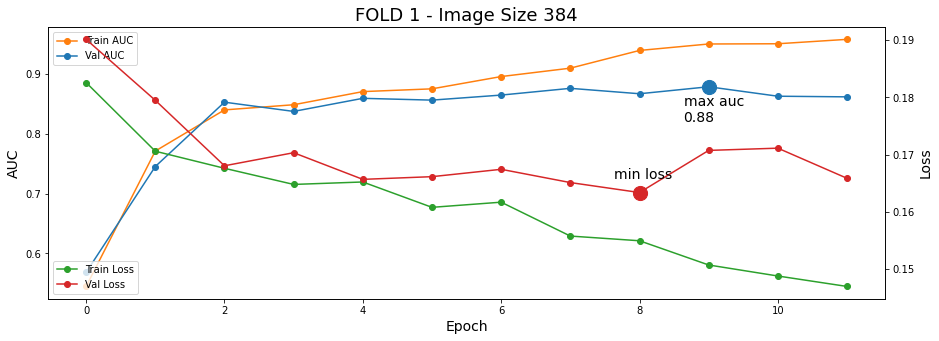

Fold: 2


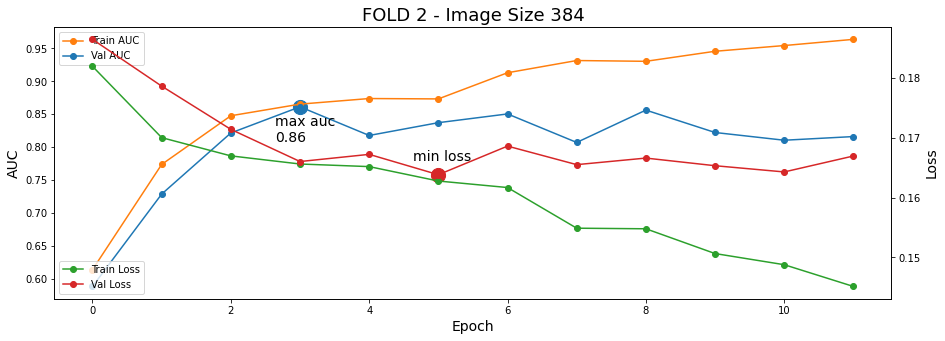

Fold: 3


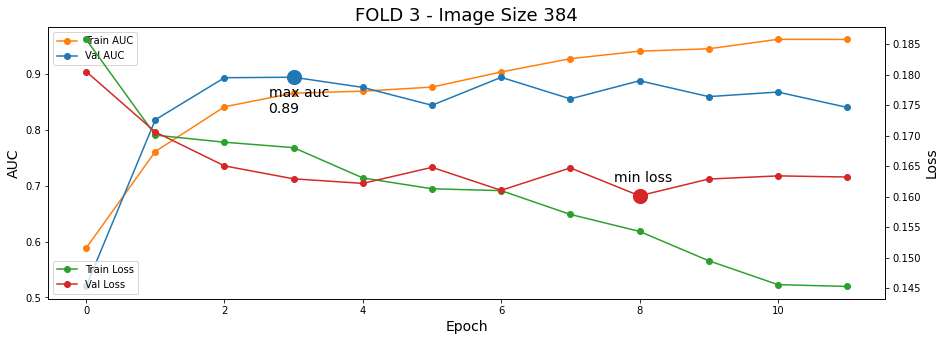

Fold: 4


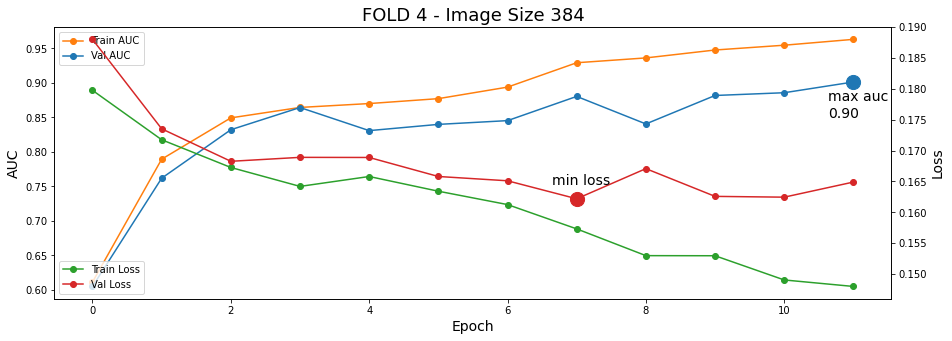

Fold: 5


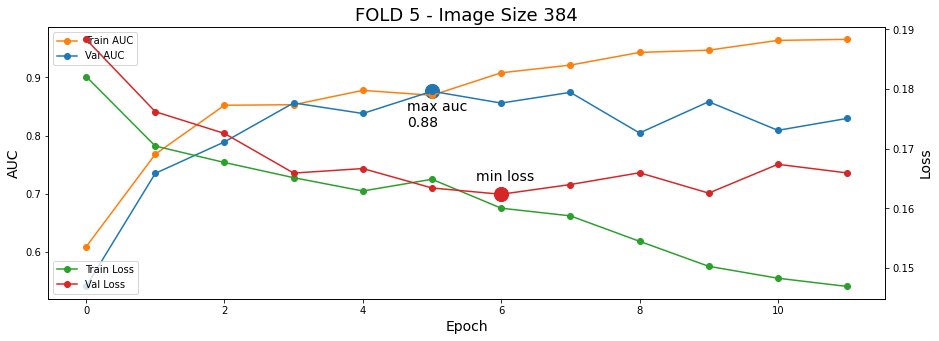

In [15]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    ##### Plot metrics #####
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(config['EPOCHS']), history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(config['EPOCHS']), history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(config['EPOCHS']), history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(config['EPOCHS']), history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

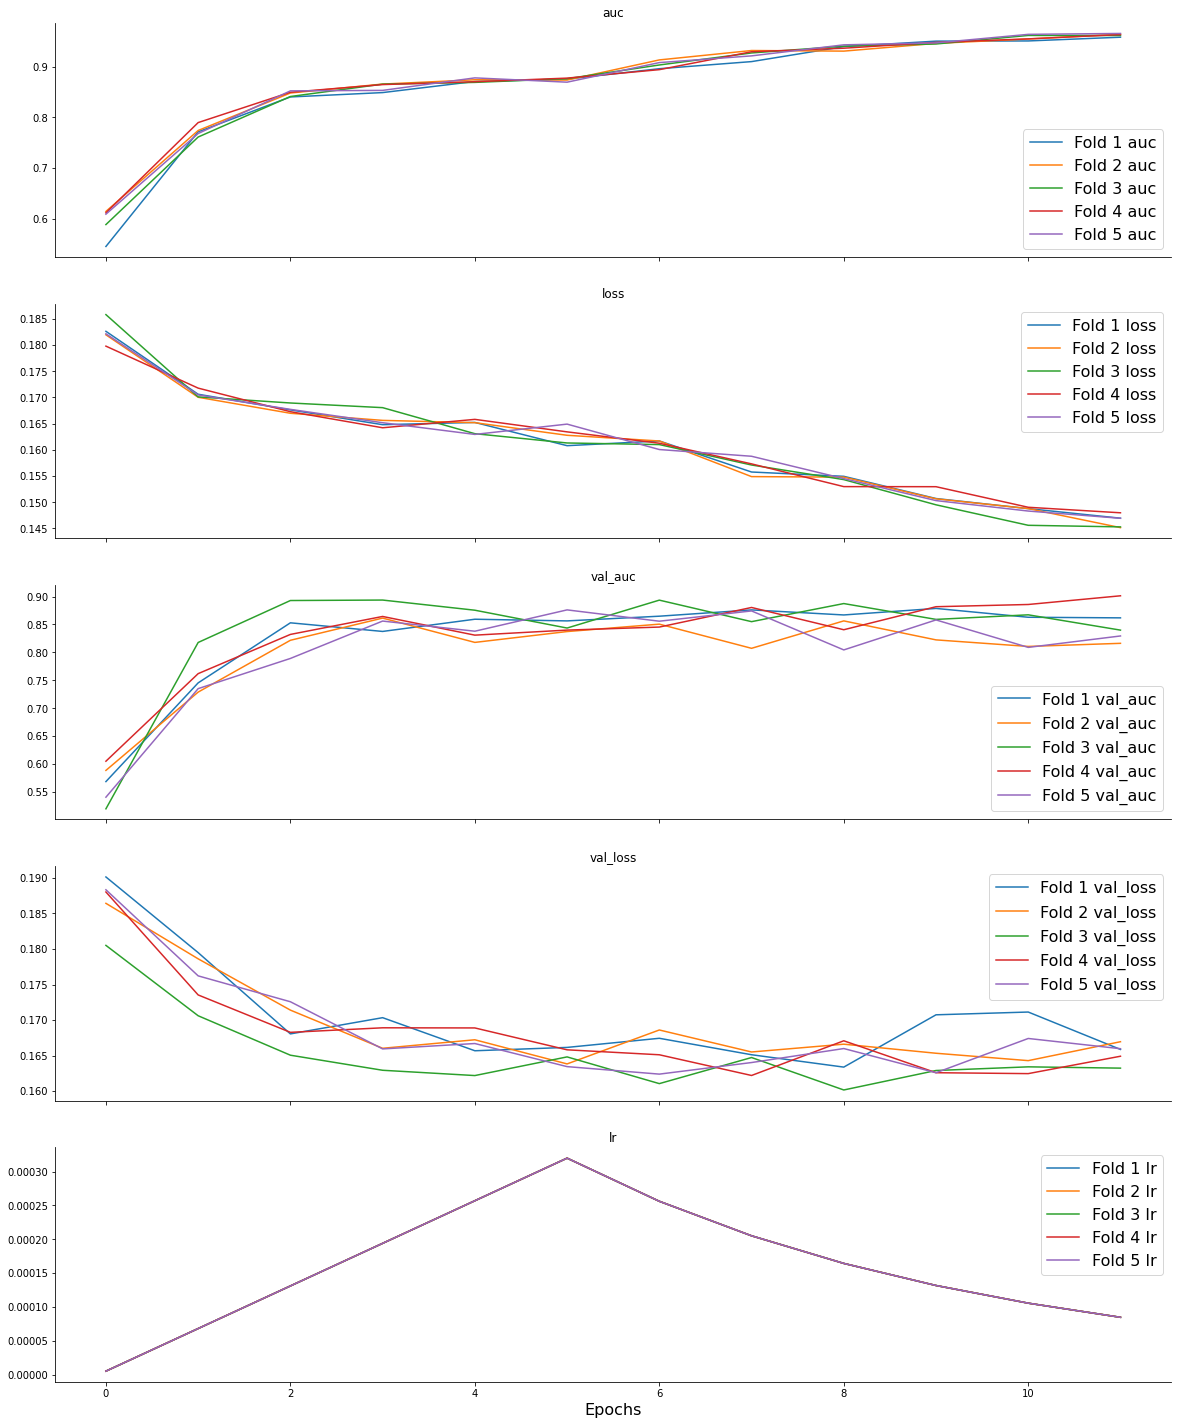

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [17]:
#@title
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f' % auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, target=true, pred=oof, fold=folds))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.902


,image_name,target,pred,fold
0,ISIC_2637011,0,0.033238,0
1,ISIC_0076262,0,0.021996,0
2,ISIC_0074268,0,0.026509,0
3,ISIC_0015719,0,0.026572,0
4,ISIC_0082543,0,0.022674,0


# Visualize test predictions

Test predictions 19|10963
Top 10 samples


,image_name,target
9905,ISIC_0052060,0.030146
1443,ISIC_0052349,0.023649
3120,ISIC_0058510,0.024872
4870,ISIC_0073313,0.025143
5494,ISIC_0073502,0.027178
4537,ISIC_0074618,0.033831
4819,ISIC_0076801,0.026135
7203,ISIC_0077586,0.032808
10897,ISIC_0082004,0.032072
5093,ISIC_0082785,0.029547


Top 10 positive samples


,image_name,target
8178,ISIC_0936377,0.761840
1408,ISIC_1593714,0.551872
8184,ISIC_2002073,0.500653
7042,ISIC_2560699,0.784085
468,ISIC_2839742,0.927084
3637,ISIC_2900150,0.529754
7981,ISIC_4000026,0.608658
10210,ISIC_4359352,0.744271
7730,ISIC_4975524,0.752672
318,ISIC_5423741,0.593506


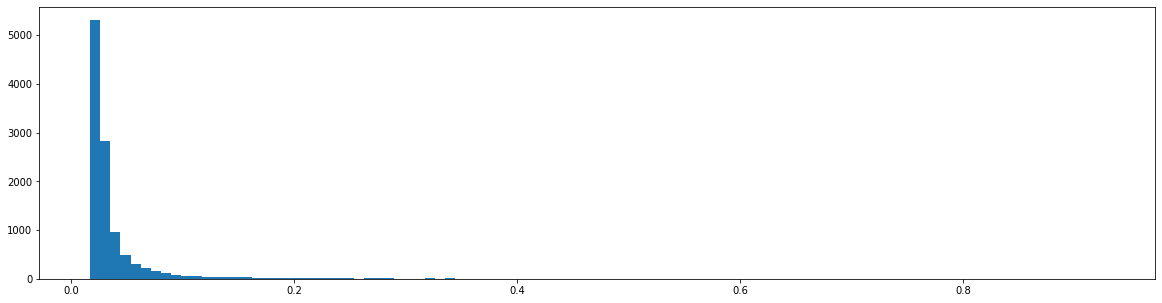

In [18]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target'], bins=100)
plt.show()

# Test set predictions

In [19]:
#@title
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
9905,ISIC_0052060,0.030146
1443,ISIC_0052349,0.023649
3120,ISIC_0058510,0.024872
4870,ISIC_0073313,0.025143
5494,ISIC_0073502,0.027178
4537,ISIC_0074618,0.033831
4819,ISIC_0076801,0.026135
7203,ISIC_0077586,0.032808
10897,ISIC_0082004,0.032072
5093,ISIC_0082785,0.029547


,target
count,10982.000000
mean,0.039954
std,0.047176
min,0.017215
25%,0.023963
50%,0.026570
75%,0.036013
max,0.927084
